# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [7]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

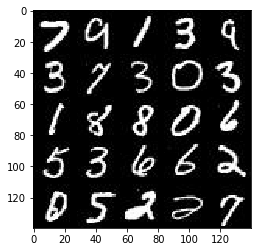

In [8]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

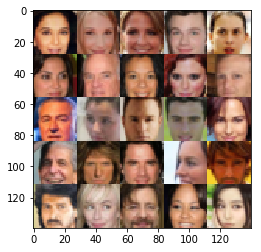

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [11]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, (None), name='learning_rate')

    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = .2
        keep_prob = .8
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1, keep_prob)
       
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    if is_train:
        reuse = False
    else:
        reuse = True
    
    with tf.variable_scope('generator', reuse=reuse):
        alpha = .2
        keep_prob  = .2
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob)
        
        # Output layer
        x4 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(x4, [28,28])
        out = tf.tanh(logits)
        return out   

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = .2
    smooth = .1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, l = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    n_images = 17 
    print_every = 50
    show_every = 150
    
    sample_z = np.random.uniform(-1, 1, size=(9, z_dim))
    samples, losses = [], []
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5493... Generator Loss: 2.6212
Epoch 1/2... Discriminator Loss: 0.6270... Generator Loss: 2.3879
Epoch 1/2... Discriminator Loss: 0.6960... Generator Loss: 2.2774


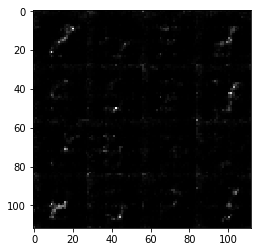

Epoch 1/2... Discriminator Loss: 0.6227... Generator Loss: 2.5556
Epoch 1/2... Discriminator Loss: 0.8372... Generator Loss: 1.8789
Epoch 1/2... Discriminator Loss: 0.7388... Generator Loss: 2.4132


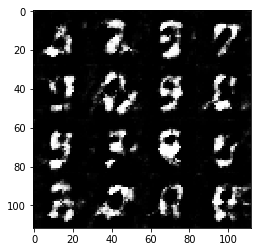

Epoch 1/2... Discriminator Loss: 0.7684... Generator Loss: 2.1119
Epoch 1/2... Discriminator Loss: 0.6715... Generator Loss: 1.6994
Epoch 1/2... Discriminator Loss: 0.6298... Generator Loss: 2.4305


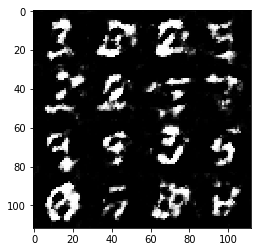

Epoch 1/2... Discriminator Loss: 0.7300... Generator Loss: 1.7495
Epoch 1/2... Discriminator Loss: 0.8413... Generator Loss: 1.2006
Epoch 1/2... Discriminator Loss: 0.6402... Generator Loss: 1.9883


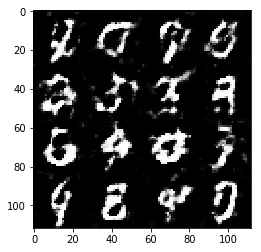

Epoch 1/2... Discriminator Loss: 0.6451... Generator Loss: 2.0424
Epoch 1/2... Discriminator Loss: 0.7196... Generator Loss: 3.3255
Epoch 1/2... Discriminator Loss: 0.6438... Generator Loss: 2.2136


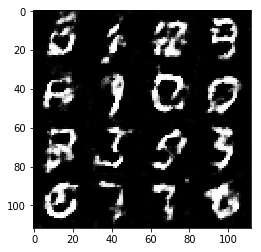

Epoch 1/2... Discriminator Loss: 0.8677... Generator Loss: 3.8483
Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 2.8215
Epoch 1/2... Discriminator Loss: 0.8338... Generator Loss: 1.2733


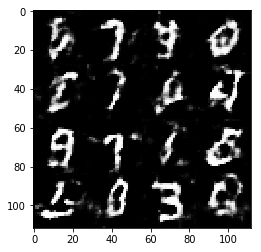

Epoch 2/2... Discriminator Loss: 0.6676... Generator Loss: 1.8856
Epoch 2/2... Discriminator Loss: 0.6512... Generator Loss: 2.1702
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 0.9914


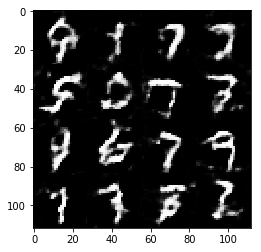

Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 2.1626
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 1.3353
Epoch 2/2... Discriminator Loss: 0.6028... Generator Loss: 2.5480


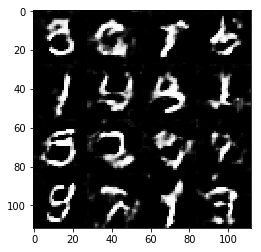

Epoch 2/2... Discriminator Loss: 0.6425... Generator Loss: 2.9797
Epoch 2/2... Discriminator Loss: 0.6515... Generator Loss: 1.5922
Epoch 2/2... Discriminator Loss: 0.5813... Generator Loss: 2.4475


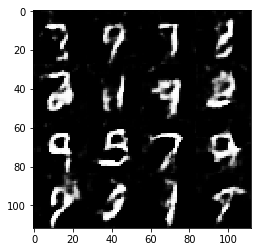

Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 1.5768
Epoch 2/2... Discriminator Loss: 0.6850... Generator Loss: 2.2780
Epoch 2/2... Discriminator Loss: 0.7339... Generator Loss: 3.5284


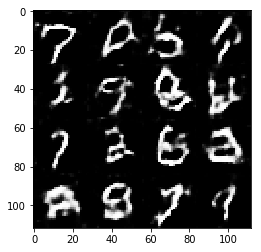

Epoch 2/2... Discriminator Loss: 0.8576... Generator Loss: 2.0019
Epoch 2/2... Discriminator Loss: 0.9649... Generator Loss: 3.6735
Epoch 2/2... Discriminator Loss: 0.6518... Generator Loss: 3.0221


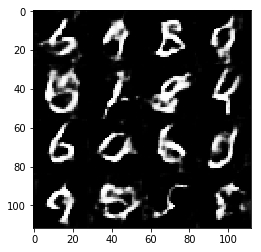

Epoch 2/2... Discriminator Loss: 0.5387... Generator Loss: 2.5150
Epoch 2/2... Discriminator Loss: 0.6834... Generator Loss: 2.4527
Epoch 2/2... Discriminator Loss: 0.7046... Generator Loss: 1.9568


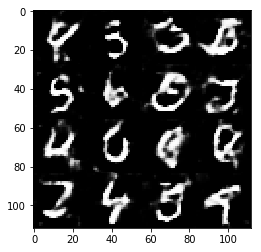

Epoch 2/2... Discriminator Loss: 0.5880... Generator Loss: 2.4974


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 4.8018
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 3.2894
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 3.2823


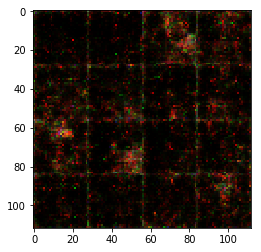

Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 4.5831
Epoch 1/1... Discriminator Loss: 0.3895... Generator Loss: 3.9556
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 3.4063


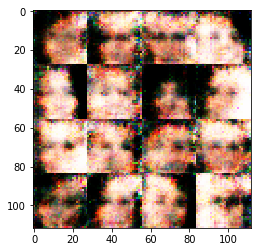

Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 2.5699
Epoch 1/1... Discriminator Loss: 2.8660... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 3.9729


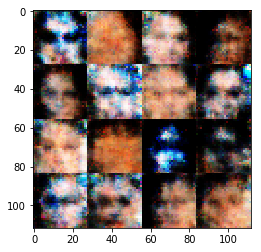

Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 1.7121
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 2.2717
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 2.4488


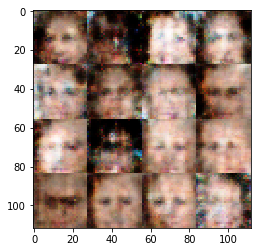

Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 2.9694
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 1.8403
Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 3.2523


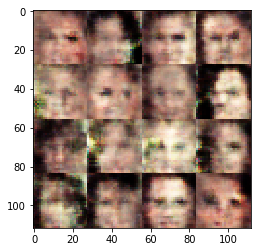

Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 3.1618
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.5773
Epoch 1/1... Discriminator Loss: 0.6133... Generator Loss: 2.6512


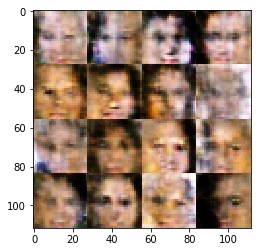

Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 2.9955
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 2.4095
Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 2.1781


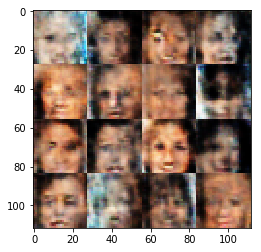

Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 1.8780
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 2.7798
Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 2.6200


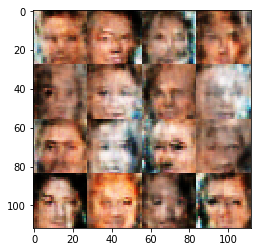

Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 2.6413
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 2.5667
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 2.4484


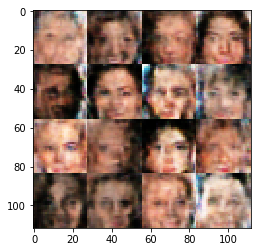

Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 2.7159
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 2.0003
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 3.0229


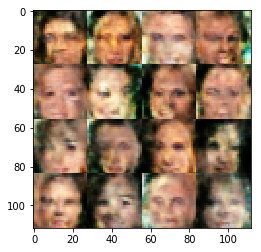

Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 2.0491
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 1.9435
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 1.5278


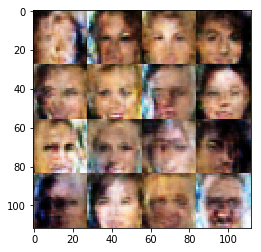

Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 1.3302
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 2.3402
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 2.2952


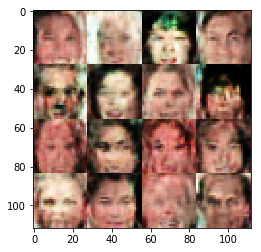

Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.9532
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.3147
Epoch 1/1... Discriminator Loss: 0.5735... Generator Loss: 1.9286


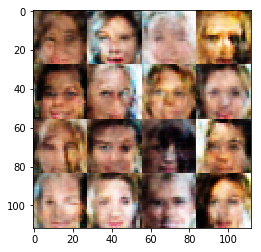

Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 2.1716
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 3.3895
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 2.5216


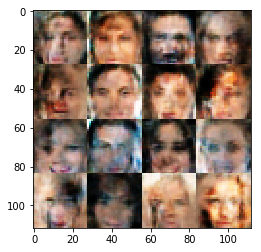

Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.9618
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 2.2454
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6956


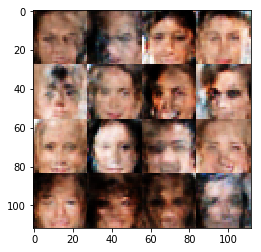

Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 3.9363
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.6041
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 2.1586


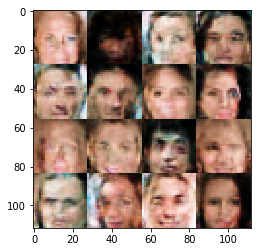

Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 2.3553
Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 2.1638
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 2.4595


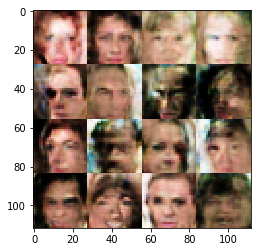

Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 1.5505
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 2.4799
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 3.9659


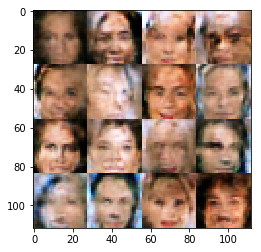

Epoch 1/1... Discriminator Loss: 0.6934... Generator Loss: 4.1301
Epoch 1/1... Discriminator Loss: 0.6768... Generator Loss: 2.0157
Epoch 1/1... Discriminator Loss: 0.5727... Generator Loss: 2.5733


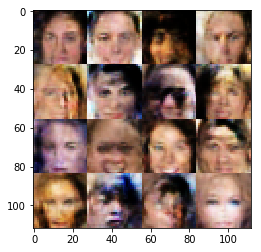

Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.5012
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 2.0420
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.5432


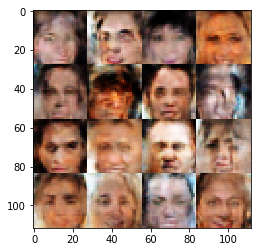

Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 2.6414
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 1.7875
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 2.0597


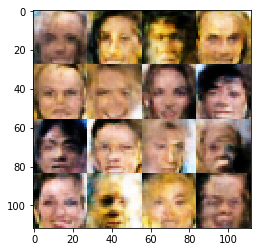

Epoch 1/1... Discriminator Loss: 0.5668... Generator Loss: 2.4918
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 2.3419


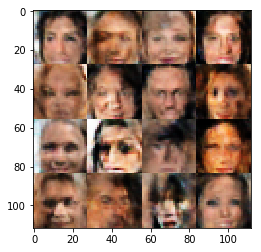

Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 3.4564
Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 2.6890
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 3.1875


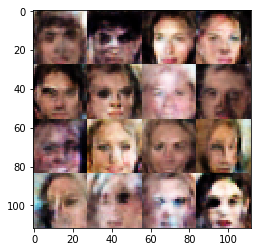

Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 3.3312
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 2.5925


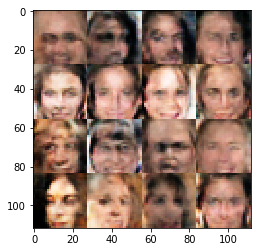

Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.4916
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 4.1450
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 2.3302


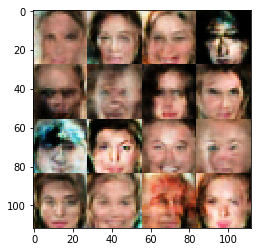

Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 2.5117
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 2.5202
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.7917


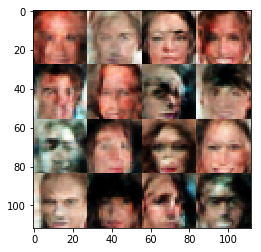

Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 2.7325
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 2.0410
Epoch 1/1... Discriminator Loss: 0.4620... Generator Loss: 3.2900


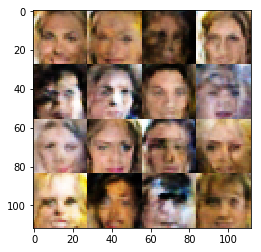

Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 2.6309
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 2.5240
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 3.0225


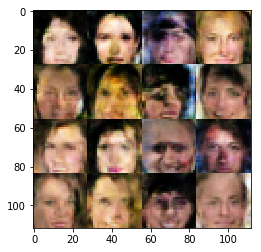

Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 2.2461
Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 3.1780
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 2.2948


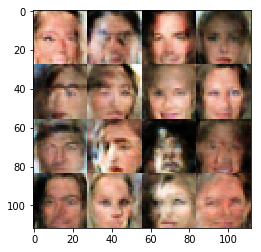

Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 2.0920
Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 4.0428
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 3.0269


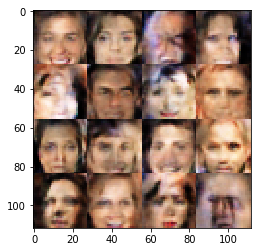

Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 2.3612
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 3.1996
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 2.9624


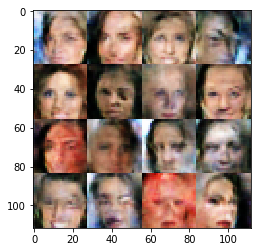

Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.9085
Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 2.7001
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 4.0366


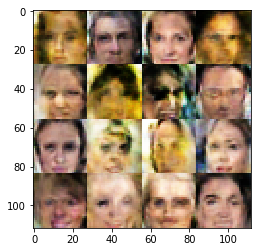

Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 3.0759
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 4.1723
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.3962


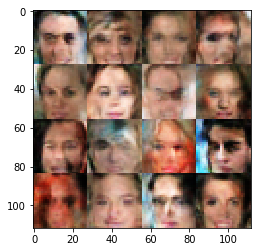

Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 3.0301
Epoch 1/1... Discriminator Loss: 0.4849... Generator Loss: 3.1846
Epoch 1/1... Discriminator Loss: 0.4754... Generator Loss: 3.1465


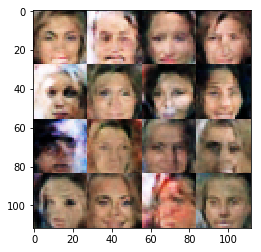

Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 3.6690
Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 3.8003
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 2.2739


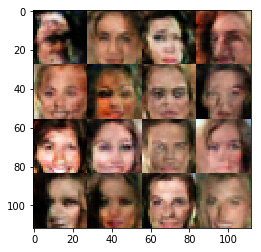

Epoch 1/1... Discriminator Loss: 0.5103... Generator Loss: 3.3464
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 3.5167
Epoch 1/1... Discriminator Loss: 0.4723... Generator Loss: 2.5750


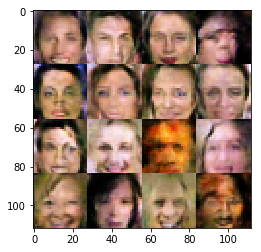

Epoch 1/1... Discriminator Loss: 0.5906... Generator Loss: 2.9310
Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 2.6871
Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 3.5248


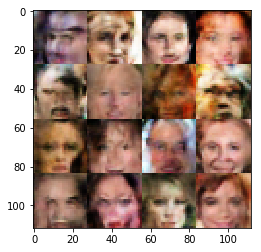

Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 2.4802
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 3.5567
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 2.4659


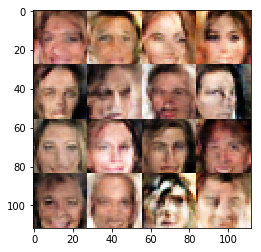

Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 3.8221
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 2.0372
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 3.1057


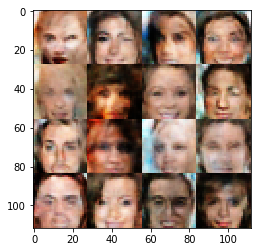

Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 4.2896
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 3.2370
Epoch 1/1... Discriminator Loss: 0.7120... Generator Loss: 2.2140


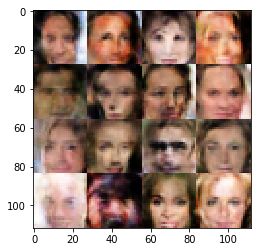

Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 2.5454
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 2.4106
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 2.4077


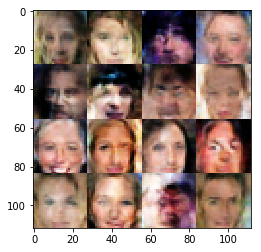

Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 2.3895
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 2.7003
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 2.0462


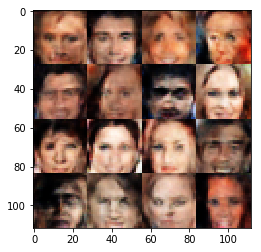

In [ ]:
batch_size = 32
z_dim = 90
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.